Epoch 1/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - biofert_accuracy: 0.2664 - biofert_loss: 1.6250 - biofert_precision_31: 0.3631 - erosion_accuracy: 0.3620 - erosion_loss: 1.1268 - erosion_precision_30: 0.4056 - loss: 2.7518 - val_biofert_accuracy: 0.3616 - val_biofert_loss: 1.4641 - val_biofert_precision_31: 1.0000 - val_erosion_accuracy: 0.5370 - val_erosion_loss: 1.0438 - val_erosion_precision_30: 0.6154 - val_loss: 2.5078
Epoch 2/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - biofert_accuracy: 0.3289 - biofert_loss: 1.5135 - biofert_precision_31: 0.5413 - erosion_accuracy: 0.4595 - erosion_loss: 1.0627 - erosion_precision_30: 0.5094 - loss: 2.5762 - val_biofert_accuracy: 0.3616 - val_biofert_loss: 1.4035 - val_biofert_precision_31: 0.9000 - val_erosion_accuracy: 0.5616 - val_erosion_loss: 1.0132 - val_erosion_precision_30: 0.8500 - val_loss: 2.4168
Epoch 3/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - biofert_accuracy: 0.3787 - biofert_loss: 1.4405 - biofert_precision_31: 0.6253 -

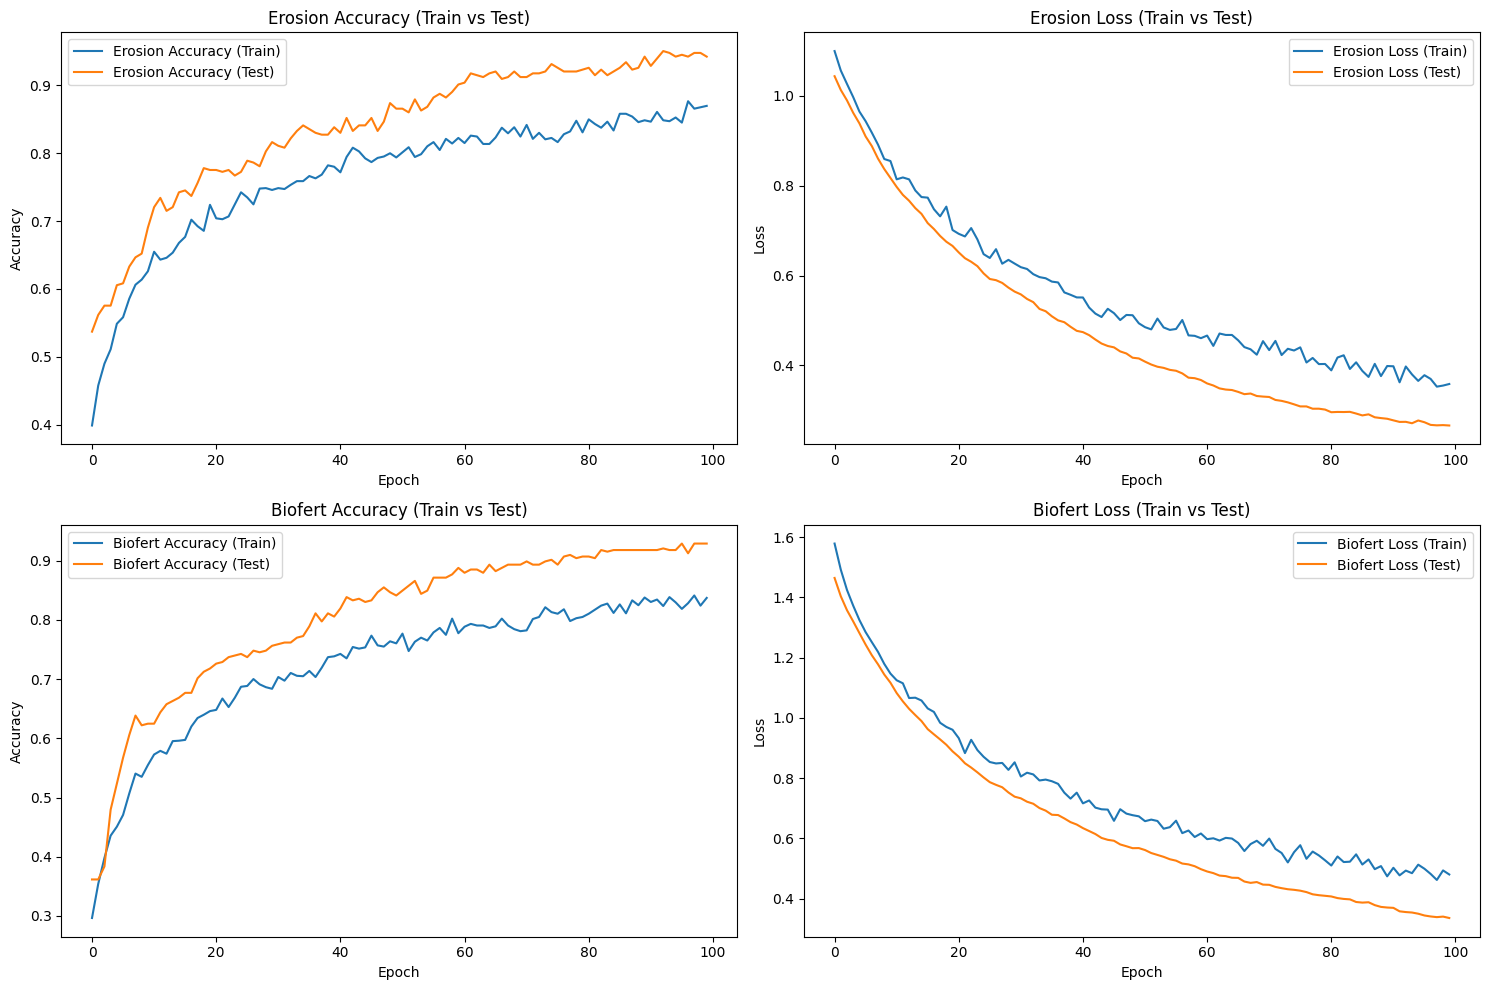

In [90]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Precision
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

#reading the data
df = pd.read_csv("datasoil.csv")
df["Optimal Biofertilizer Formulation"] = df["Optimal Biofertilizer Formulation"].replace("Formultaion E", "Formulation E")


X = df.drop(columns=["Sample ID", "Erosion Risk", "Optimal Biofertilizer Formulation"])

le_erosion = LabelEncoder()
le_bio = LabelEncoder()

y1 = le_erosion.fit_transform(df["Erosion Risk"])
y2 = le_bio.fit_transform(df["Optimal Biofertilizer Formulation"])

#preprocessing
ohe = OneHotEncoder(sparse_output=False)
y1_ohe = ohe.fit_transform(y1.reshape(-1, 1))
y2_ohe = ohe.fit_transform(y2.reshape(-1, 1))


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#training and testing
X_train, X_test, y1_train, y1_test, y2_train, y2_test = train_test_split(
    X_scaled, y1_ohe, y2_ohe, test_size=0.2, random_state=42
)


inputs = Input(shape=(X_train.shape[1],))
x = Dense(64, activation='relu')(inputs)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)


erosion_output = Dense(y1_ohe.shape[1], activation='softmax', name="erosion")(x)
bio_output = Dense(y2_ohe.shape[1], activation='softmax', name="biofert")(x)

model = Model(inputs=inputs, outputs=[erosion_output, bio_output])

#using the deeplearning model
model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss={'erosion': 'categorical_crossentropy', 'biofert': 'categorical_crossentropy'},
    metrics={
        'erosion': ['accuracy', Precision()],
        'biofert': ['accuracy', Precision()]
    }
)


early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


history = model.fit(
    X_train,
    {'erosion': y1_train, 'biofert': y2_train},
    validation_data=(X_test, {'erosion': y1_test, 'biofert': y2_test}),
    epochs=100,
    batch_size=16,
    callbacks=[early_stop],
    verbose=1
)

# Plotting the required graphs
def plot_training_curves(history):
    plt.figure(figsize=(15, 10))


    plt.subplot(2, 2, 1)
    plt.plot(history.history['erosion_accuracy'], label='Erosion Accuracy (Train)')
    plt.plot(history.history['val_erosion_accuracy'], label='Erosion Accuracy (Test)')
    plt.title('Erosion Accuracy (Train vs Test)')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()


    plt.subplot(2, 2, 2)
    plt.plot(history.history['erosion_loss'], label='Erosion Loss (Train)')
    plt.plot(history.history['val_erosion_loss'], label='Erosion Loss (Test)')
    plt.title('Erosion Loss (Train vs Test)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(2, 2, 3)
    plt.plot(history.history['biofert_accuracy'], label='Biofert Accuracy (Train)')
    plt.plot(history.history['val_biofert_accuracy'], label='Biofert Accuracy (Test)')
    plt.title('Biofert Accuracy (Train vs Test)')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(2, 2, 4)
    plt.plot(history.history['biofert_loss'], label='Biofert Loss (Train)')
    plt.plot(history.history['val_biofert_loss'], label='Biofert Loss (Test)')
    plt.title('Biofert Loss (Train vs Test)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_curves(history)



In [91]:
from sklearn.metrics import r2_score
import numpy as np


y_pred_erosion, y_pred_bio = model.predict(X_test)


r2_erosion = r2_score(y1_test, y_pred_erosion)
r2_bio = r2_score(y2_test, y_pred_bio)

print("R² Score - Erosion Risk:", round(r2_erosion, 4))
print("R² Score - Biofertilizer Formulation:", round(r2_bio, 4))


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
R² Score - Erosion Risk: 0.8379
R² Score - Biofertilizer Formulation: 0.8186


In [95]:
sample_input = np.array([[2.5,#Soil Salinity (EC)
                          6.8,#Soil pH
                          3.2,#Organic Matter Content (%)
                          25.0,#Soil Moisture (%)
                          15.0,#Nitrogen (mg/kg)
                          10.0,#Phosphorus (mg/kg)
                          200.0,#Potassium (mg/kg)
                          40.0,#Sand (%)
                          30.0,#Silt (%)
                          30.0,#Clay (%)
                          5e6,#Microbial Activity (CFU/g)
                           12.0,#CEC (meq/100g)
                          5.0#SAR
                          ]])
sample_df = pd.DataFrame(sample_input, columns=X.columns)
sample_scaled = scaler.transform(sample_df)


pred_erosion, pred_bio = model.predict(sample_scaled)


pred_erosion_label = np.argmax(pred_erosion)
pred_bio_label = np.argmax(pred_bio)


erosion_mapping = {0: "Low", 1: "Medium", 2: "High", 3: "Very High", 4: "Extreme"}
biofert_mapping = {0: "Formulation A", 1: "Formulation B", 2: "Formulation C", 3: "Formulation D", 4: "Formulation E"}


print("Predicted Erosion Risk:", erosion_mapping[pred_erosion_label])
print("Predicted Biofertilizer Formulation:", biofert_mapping[pred_bio_label])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Predicted Erosion Risk: Medium
Predicted Biofertilizer Formulation: Formulation A
